Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
# Wrangle train and test in the same way

import numpy as np

def wrangle(X):
  # avoid copy warning
  X = X.copy()

  # replace incorrect latitudes with 0
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  X['construction_year'] = X['construction_year'].replace(0, np.NaN)

  # replace zeros with NaNs
  cols_with_zeros = ['latitude', 'longitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # drop a redundant column
  X = X.drop(columns='quantity_group')

  return X

train = wrangle(train)
test = wrangle(test)

target = 'status_group'


# Get a df with all features except the target and id
train_features = train.drop(columns=[target, 'id'])

# get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get the cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# combine the two lists
features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_test = test[features]

In [5]:
# Do cross-validation on train

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 3 folds: [0.79984848 0.80237374 0.79621212]


In [7]:
# Do hyperparameter optimization with RandomizedSearchCV

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [20], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.1min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.5min finished


In [8]:
# get best parameters

print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.2637394735664039, 'randomforestclassifier__n_estimators': 491, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.8056228956228956


In [9]:
# use best estimator to predict test data, then .to_csv

pipeline = search.best_estimator_

y_pred = pipeline.predict(X_test)

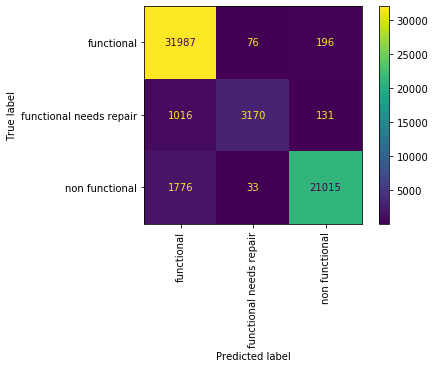

In [11]:
import sklearn
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_train, y_train, values_format='.0f', xticks_rotation='vertical');